In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('behavior.csv')
data = data.drop_duplicates()
data

,user_id,item_id,behavior_type,item_category,time,hour
0,3818035,769273,1,35830,2022/12/9,2
1,4044659,210740,1,5987,2022/12/9,23
2,3846307,701988,1,570,2022/12/9,17
3,4225075,696487,1,46141,2022/12/9,21
4,3668163,203207,1,1273,2022/12/9,6
...,...,...,...,...,...,...
199785,4045155,293868,4,44201,2022/12/19,23
199786,4138787,84663,4,29398,2022/12/19,15
199787,4081747,371179,4,6078,2022/12/19,17
199788,3571059,215886,4,30899,2022/12/19,18


## 1. 用户行为 漏斗模型
### 1）日新增用户

In [2]:
data['time'].unique()

array(['2022/12/9', '2022/12/10', '2022/12/11', '2022/12/12',
       '2022/12/13', '2022/12/14', '2022/12/15', '2022/12/16',
       '2022/12/17', '2022/12/18', '2022/12/19'], dtype=object)

In [3]:
user = set(data[data['time']=='2022/12/9']['user_id']) # initialize user list
new_user = []
for i in range(9,20):
    s = set(data[data['time']==f'2022/12/{i}']['user_id'])
    new_user.append(s.difference(user))
    user = user.union(s)
num_new_user = [len(i) for i in new_user]
num_new_user

[0, 6454, 5655, 5334, 4852, 4447, 3878, 3579, 3260, 3007, 2657]

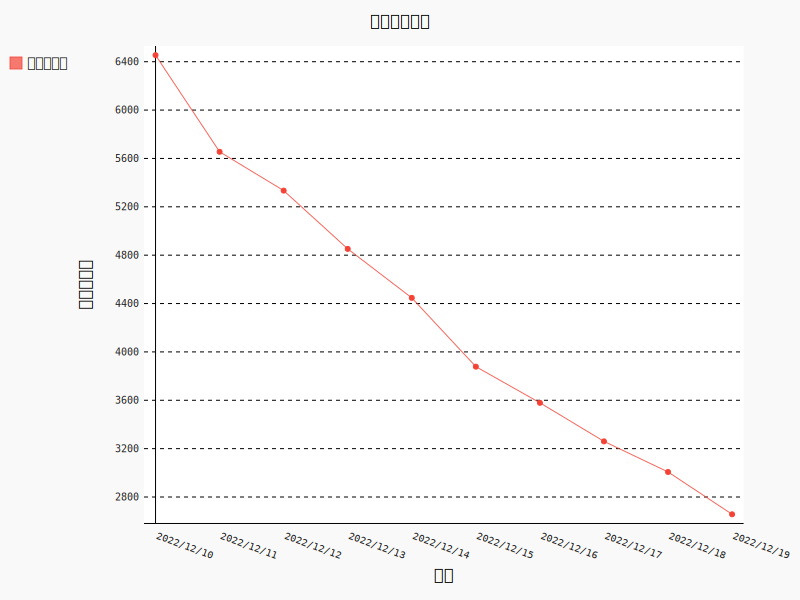

In [4]:
import pygal
from IPython.display import SVG, display

line_chart = pygal.Line(x_label_rotation=20)
line_chart.title = '日新增用户图'
line_chart.x_title = '日期'
line_chart.y_title = '新增用户数'
line_chart.x_labels = map(str, list(data['time'].unique())[1:])
line_chart.add('新增用户数',num_new_user[1:])
display(SVG(line_chart.render(disable_xml_declaration=True)))
line_chart.render_to_file('日新增用户图.svg')

### 2）用户行为漏斗图

In [6]:
behavior = data[['user_id','behavior_type']]
behavior = behavior.drop_duplicates()
behavior = behavior.groupby(by=['behavior_type'], as_index=False)['user_id'].count()
behavior

,behavior_type,user_id
0,1,50000
1,2,17368
2,3,37302
3,4,37518


In [7]:
behavior['user_id'][2] = len(set(data[data['behavior_type']==3]['user_id'].unique()).union(
    set(data[data['behavior_type']==4]['user_id'].unique())))
behavior

,behavior_type,user_id
0,1,50000
1,2,17368
2,3,47226
3,4,37518


In [8]:
from pyecharts import options as opts
from pyecharts.charts import Funnel

c = Funnel()
c.add('各阶段数据', [list(z) for z in zip(['点击','收藏','加购','购买'],behavior['user_id'])],
      label_opts = opts.LabelOpts(font_size=13, position='right', formatter = '{b} {c}'))
c.set_global_opts(title_opts=opts.TitleOpts(title='用户行为漏斗图'))
c.render('用户行为漏斗图.html')
c.render_notebook()

In [9]:
c = Funnel()
c.add('各阶段数据', [list(z) for z in zip(['点击','收藏','加购','购买'], list(behavior['user_id']*100/50000))],
      label_opts = opts.LabelOpts(font_size=13, position='right', formatter = '{b} {c}%'))
c.set_global_opts(title_opts=opts.TitleOpts(title='用户行为占比漏斗图'))
c.render('用户行为占比漏斗图.html')
c.render_notebook()

### 3）新用户留存数量表格

In [10]:
left = pd.concat([pd.DataFrame(data['time'].unique()), pd.DataFrame(num_new_user)], axis=1)
left = left.iloc[1:10,:]
left2 = left.copy()
left.columns = ['date','new_user']
left2.columns = ['date','new_user']
left

,date,new_user
1,2022/12/10,6454
2,2022/12/11,5655
3,2022/12/12,5334
4,2022/12/13,4852
5,2022/12/14,4447
6,2022/12/15,3878
7,2022/12/16,3579
8,2022/12/17,3260
9,2022/12/18,3007


In [12]:
new_users = new_user[1:]

for i in range(1,10):
    left[f'{i}日后'] = [0]*9

for i in range(10,19):
    for j in range(1,10):
        idx = i-10
        user_today = new_users[idx]
        user_compare = data[data['time'] == f'2022/12/{i+j}']['user_id'].unique()
        num = len([i for i in user_today if i in user_compare])
        if num:
            left[f'{j}日后'][idx+1] = num
left.replace(0, '')

,date,new_user,1日后,2日后,3日后,4日后,5日后,6日后,7日后,8日后,9日后
1,2022/12/10,6454,569,570,574,551,528,550,545,538,581
2,2022/12/11,5655,478,506,514,545,501,488,508,536,
3,2022/12/12,5334,461,484,473,474,482,460,463,,
4,2022/12/13,4852,464,442,452,465,453,433,,,
5,2022/12/14,4447,418,383,428,458,405,,,,
6,2022/12/15,3878,373,375,354,382,,,,,
7,2022/12/16,3579,341,329,327,,,,,,
8,2022/12/17,3260,284,326,,,,,,,
9,2022/12/18,3007,307,,,,,,,,


### 4）新用户留存率表格

In [13]:
for i in range(1,10):
    left2[f'{i}日后留存率(%)'] = left[f'{i}日后']/left['new_user']*100
left2.replace(0, '')

,date,new_user,1日后留存率(%),2日后留存率(%),3日后留存率(%),4日后留存率(%),5日后留存率(%),6日后留存率(%),7日后留存率(%),8日后留存率(%),9日后留存率(%)
1,2022/12/10,6454,8.816238,8.831732,8.893709,8.537341,8.180973,8.521847,8.444376,8.335916,9.002169
2,2022/12/11,5655,8.452697,8.947834,9.089302,9.637489,8.859416,8.629531,8.983201,9.478338,
3,2022/12/12,5334,8.642670,9.073866,8.867642,8.886389,9.03637,8.623922,8.680165,,
4,2022/12/13,4852,9.563067,9.109646,9.315746,9.583677,9.336356,8.924155,,,
5,2022/12/14,4447,9.399595,8.612548,9.624466,10.299078,9.107263,,,,
6,2022/12/15,3878,9.618360,9.669933,9.128417,9.850438,,,,,
7,2022/12/16,3579,9.527801,9.192512,9.13663,,,,,,
8,2022/12/17,3260,8.711656,10.0,,,,,,,
9,2022/12/18,3007,10.209511,,,,,,,,


### 5）用户复购统计分布图

In [83]:
repur = data[data['behavior_type']==4]
repur = repur.groupby(by='user_id', as_index=False)['behavior_type'].count()
repur = repur[repur['behavior_type']>1]
re_user = repur['user_id'].unique()

In [84]:
from datetime import datetime
def time_function(x):
    return datetime.strptime(str(x),'%Y/%m/%d')

repurchase = data[data['user_id'].isin(list(re_user))]
repurchase = repurchase[repurchase['behavior_type']==4]
repurchase['time'] = repurchase['time'].apply(time_function)
repurchase = pd.merge(repurchase.groupby(by='user_id', as_index=False)['time'].min(), 
                      repurchase.groupby(by='user_id', as_index=False)['time'].max(), on='user_id')
repurchase.columns = ['user_id','first_pur', 'last_pur']
repurchase['duration'] = repurchase['last_pur']-repurchase['first_pur']
repurchase['duration'] = repurchase['duration'].apply(lambda x:x.days)
repurchase

,user_id,first_pur,last_pur,duration
0,3443443,2022-12-11,2022-12-19,8
1,3444867,2022-12-09,2022-12-12,3
2,3445059,2022-12-17,2022-12-17,0
3,3445219,2022-12-16,2022-12-18,2
4,3445571,2022-12-11,2022-12-11,0
...,...,...,...,...
1714,4241123,2022-12-11,2022-12-11,0
1715,4241459,2022-12-10,2022-12-10,0
1716,4241875,2022-12-12,2022-12-15,3
1717,4241891,2022-12-13,2022-12-17,4


In [37]:
repurchase = repurchase.merge(repur, on='user_id')
repurchase = repurchase[repurchase['duration']!=0]
repurchase['frequency'] = repurchase['duration']/repurchase['behavior_type']
repurchase

,user_id,first_pur,last_pur,duration,behavior_type,frequency
0,3443443,2022-12-11,2022-12-19,8,2,4.0
1,3444867,2022-12-09,2022-12-12,3,2,1.5
3,3445219,2022-12-16,2022-12-18,2,2,1.0
5,3445891,2022-12-12,2022-12-16,4,2,2.0
6,3446259,2022-12-15,2022-12-19,4,2,2.0
...,...,...,...,...,...,...
1712,4239491,2022-12-10,2022-12-14,4,2,2.0
1713,4239891,2022-12-09,2022-12-14,5,2,2.5
1716,4241875,2022-12-12,2022-12-15,3,2,1.5
1717,4241891,2022-12-13,2022-12-17,4,2,2.0


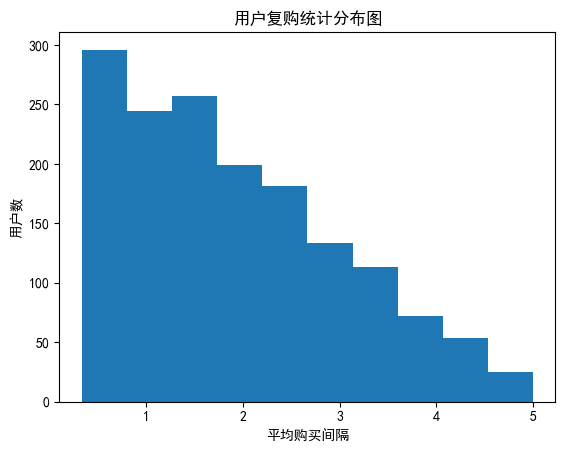

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False

plt.hist(repurchase['frequency'])
plt.title('用户复购统计分布图')
plt.xlabel('平均购买间隔')
plt.ylabel('用户数')
plt.savefig('用户复购统计分布图.png')
plt.show()

## 2. 不同时间尺度分析用户行为
### 1）以日为单位

In [39]:
df_day = pd.DataFrame(data['time'].unique())
df_day.columns = ['time']
df_day['点击数'] = 0*len(df_day)
df_day['收藏数'] = 0*len(df_day)
df_day['加购数'] = 0*len(df_day)
df_day['购买数'] = 0*len(df_day)
for i in range(9,20):
    day = data[data['time']==f'2022/12/{i}']
    df_day.iloc[i-9,1:] = list(day['behavior_type'].value_counts(sort=False))
df_day

,time,点击数,收藏数,加购数,购买数
0,2022/12/9,7186,1471,3364,3488
1,2022/12/10,7320,1715,3420,3608
2,2022/12/11,7106,1068,3448,3486
3,2022/12/12,7359,1325,3553,3719
4,2022/12/13,7341,1291,3513,3555
5,2022/12/14,7372,1836,3378,3613
6,2022/12/15,7224,1624,3334,3459
7,2022/12/16,7213,1691,3353,3576
8,2022/12/17,7256,1038,3586,3579
9,2022/12/18,7293,1825,3392,3575


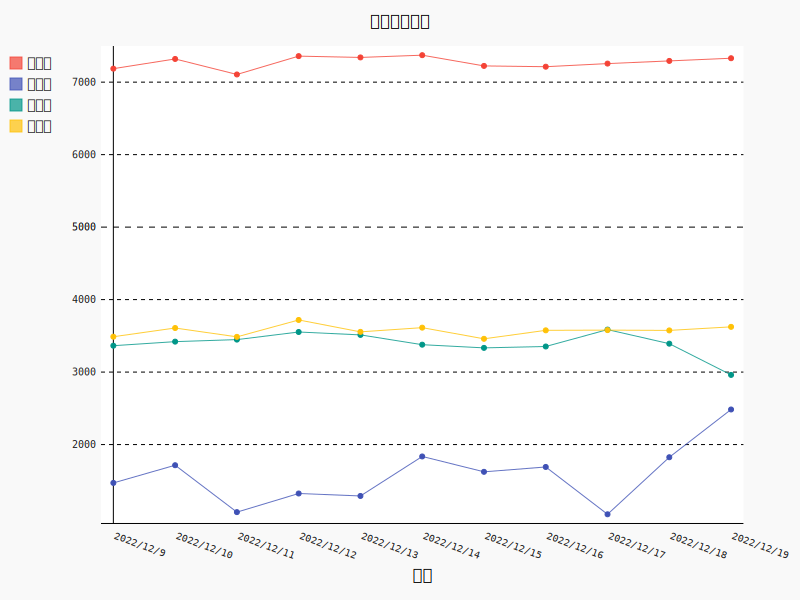

In [40]:
line_chart = pygal.Line(x_label_rotation=20)
line_chart.x_labels = map(str, df_day['time'])
line_chart.add('点击数', df_day['点击数'])
line_chart.add('收藏数', df_day['收藏数'])
line_chart.add('加购数', df_day['加购数'])
line_chart.add('购买数', df_day['购买数'])
line_chart.title = '每日用户行为'
line_chart.x_title = '日期'
display(SVG(line_chart.render(disable_xml_declaration=True)))
line_chart.render_to_file('每日用户行为.svg')

### 2）以小时为单位

In [42]:
# 2022/12/9
df_hour = pd.DataFrame(np.sort(data['hour'].unique()))
df_hour.columns = ['hour']
df_hour['点击数'] = 0*len(df_hour)
df_hour['收藏数'] = 0*len(df_hour)
df_hour['加购数'] = 0*len(df_hour)
df_hour['购买数'] = 0*len(df_hour)
day = '2022/12/9'
df_day = data[data['time']==day]
for i in range(24):
    hour = df_day[df_day['hour']==i]
    df_hour.iloc[i,1:] = list(hour['behavior_type'].value_counts(sort=False))
df_hour

,hour,点击数,收藏数,加购数,购买数
0,0,380,72,181,180
1,1,305,58,138,147
2,2,244,47,113,126
3,3,177,36,83,78
4,4,160,35,77,73
5,5,98,19,45,52
6,6,77,16,37,35
7,7,76,11,42,40
8,8,76,17,32,35
9,9,80,21,37,38


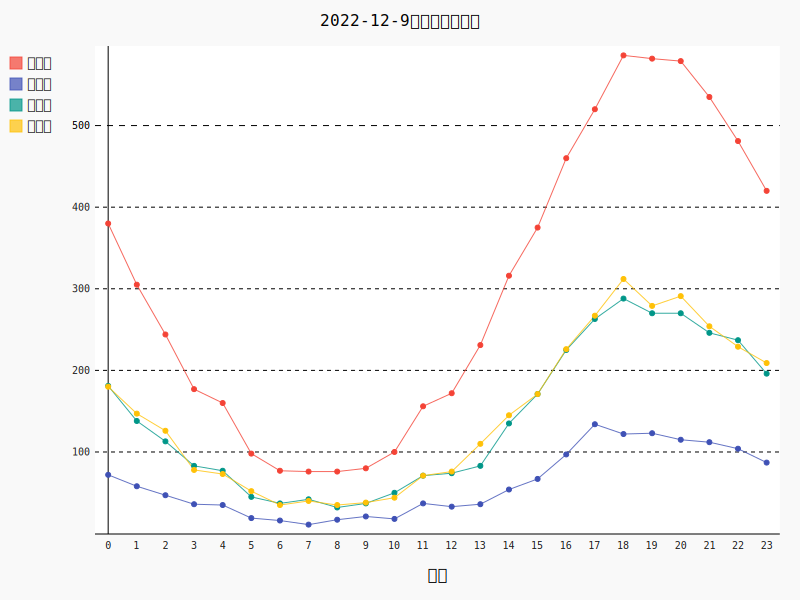

In [43]:
line_chart = pygal.Line()
line_chart.x_labels = map(str, df_hour['hour'])
line_chart.add('点击数', df_hour['点击数'])
line_chart.add('收藏数', df_hour['收藏数'])
line_chart.add('加购数', df_hour['加购数'])
line_chart.add('购买数', df_hour['购买数'])
day = day.replace('/','-')
line_chart.title = f'{day}每小时用户行为'
line_chart.x_title = '小时'
display(SVG(line_chart.render(disable_xml_declaration=True)))
line_chart.render_to_file(f'{day}每小时用户行为.svg')

## 3. RFM用户价值分层

In [66]:
purchase = data[data['behavior_type']==4]
purchase['time'] = purchase['time'].apply(time_function)
rfm = purchase.groupby(by='user_id', as_index=False)['time'].max()
rfm = rfm.merge(repurchase[['user_id', 'frequency']], how='left', on='user_id')
purchase_item = purchase[['user_id','item_id']]
purchase_item.drop_duplicates(inplace=True)
purchase_item = purchase_item.groupby(by='user_id', as_index=False)['item_id'].count()
purchase_item
rfm = rfm.merge(purchase_item, how='left', on='user_id')
rfm = rfm.replace(np.nan, 0)
rfm.columns = ['user_id','R','F','M']
rfm

,user_id,R,F,M
0,3443267,2022-12-13,0.0,1
1,3443283,2022-12-15,0.0,1
2,3443299,2022-12-15,0.0,1
3,3443315,2022-12-17,0.0,1
4,3443331,2022-12-11,0.0,1
...,...,...,...,...
37513,4243171,2022-12-11,0.0,1
37514,4243187,2022-12-16,0.0,1
37515,4243203,2022-12-15,0.0,1
37516,4243235,2022-12-11,0.0,1


In [70]:
for i in ['R','F','M']:
    rfm[f'{i}_label'] = ''*len(rfm)
    for j in range(len(rfm)):
        if rfm[i][j] > np.mean(rfm[i]):
            rfm[f'{i}_label'][j] = '+'
        else:
            rfm[f'{i}_label'][j] = '-'
rfm

,user_id,R,F,M,R_label,F_label,M_label
0,3443267,2022-12-13,0.0,1,-,-,-
1,3443283,2022-12-15,0.0,1,+,-,-
2,3443299,2022-12-15,0.0,1,+,-,-
3,3443315,2022-12-17,0.0,1,+,-,-
4,3443331,2022-12-11,0.0,1,-,-,-
...,...,...,...,...,...,...,...
37513,4243171,2022-12-11,0.0,1,-,-,-
37514,4243187,2022-12-16,0.0,1,+,-,-
37515,4243203,2022-12-15,0.0,1,+,-,-
37516,4243235,2022-12-11,0.0,1,-,-,-


In [71]:
rfm['用户价值分层'] = ''*len(rfm)
for i in range(len(rfm)):
    if rfm['R_label'][i] == '+':
        if rfm['F_label'][i] == '+':
            if rfm['M_label'][i] == '+':
                rfm['用户价值分层'][i] = '重要价值客户'
            else:
                rfm['用户价值分层'][i] = '一般价值客户'
        else:
            if rfm['M_label'][i] == '+':
                rfm['用户价值分层'][i] = '重要发展客户'
            else:
                rfm['用户价值分层'][i] = '一般发展客户'
    else:
        if rfm['F_label'][i] == '+':
            if rfm['M_label'][i] == '+':
                rfm['用户价值分层'][i] = '重要保持客户'
            else:
                rfm['用户价值分层'][i] = '一般保持客户'
        else:
            if rfm['M_label'][i] == '+':
                rfm['用户价值分层'][i] = '重要挽留客户'
            else:
                rfm['用户价值分层'][i] = '一般挽留客户'
rfm

,user_id,R,F,M,R_label,F_label,M_label,用户价值分层
0,3443267,2022-12-13,0.0,1,-,-,-,一般挽留客户
1,3443283,2022-12-15,0.0,1,+,-,-,一般发展客户
2,3443299,2022-12-15,0.0,1,+,-,-,一般发展客户
3,3443315,2022-12-17,0.0,1,+,-,-,一般发展客户
4,3443331,2022-12-11,0.0,1,-,-,-,一般挽留客户
...,...,...,...,...,...,...,...,...
37513,4243171,2022-12-11,0.0,1,-,-,-,一般挽留客户
37514,4243187,2022-12-16,0.0,1,+,-,-,一般发展客户
37515,4243203,2022-12-15,0.0,1,+,-,-,一般发展客户
37516,4243235,2022-12-11,0.0,1,-,-,-,一般挽留客户


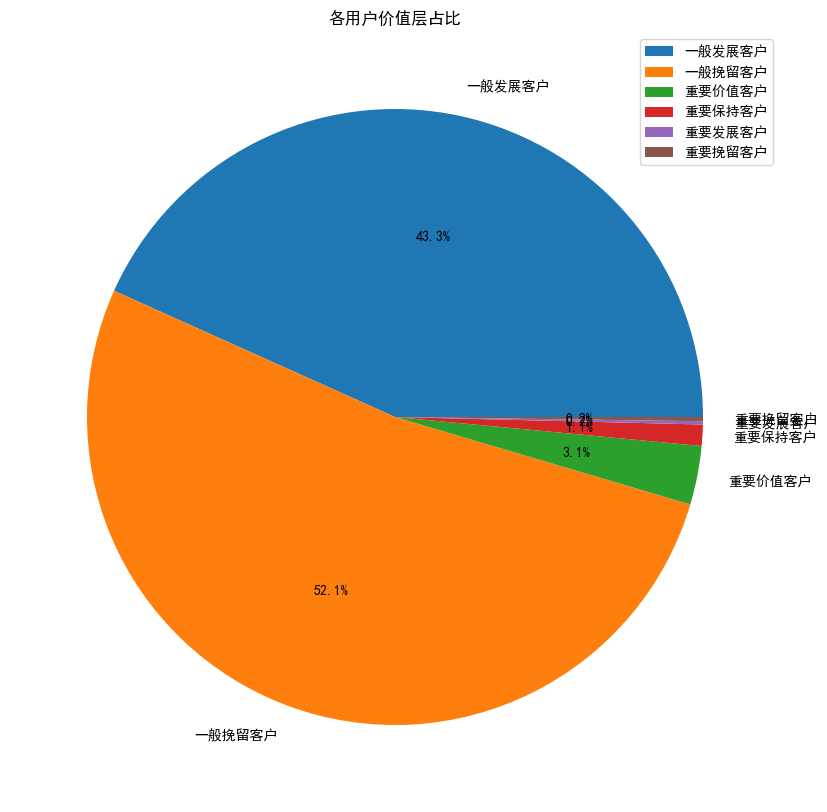

In [78]:
RFM = rfm.groupby(by=['用户价值分层'], as_index=False)['user_id'].count()
plt.figure(figsize=(10, 10))
plt.pie(RFM['user_id'], labels=RFM['用户价值分层'], autopct='%.1f%%')
plt.title('各用户价值层占比')
plt.savefig('各用户价值层占比.png')
plt.legend()
plt.show()

## 4. 商品、商品类目统计分布图
### 1）商品


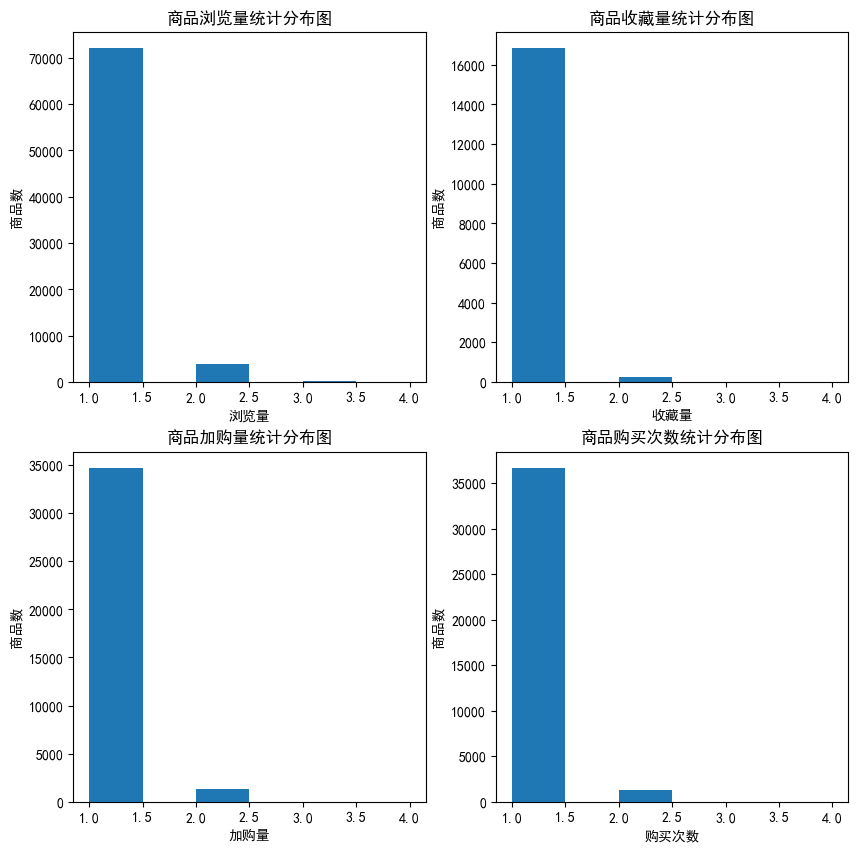

In [79]:
click = data[data['behavior_type']==1]
click = click.groupby(by='item_id', as_index=False)['user_id'].count()
favorite = data[data['behavior_type']==2]
favorite = favorite.groupby(by='item_id', as_index=False)['user_id'].count()
add = data[data['behavior_type']==3]
add = add.groupby(by='item_id', as_index=False)['user_id'].count()
purchase = data[data['behavior_type']==4]
purchase = purchase.groupby(by='item_id', as_index=False)['user_id'].count()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax1 = axes[0][0]
ax2 = axes[0][1]
ax3 = axes[1][0]
ax4 = axes[1][1]

ax1.hist(click['user_id'], bins = np.linspace(1.0, 4.0, 7))
ax1.set_title('商品浏览量统计分布图')
ax1.set_xlabel('浏览量')
ax1.set_ylabel('商品数')
ax2.hist(favorite['user_id'], bins = np.linspace(1.0, 4.0, 7))
ax2.set_title('商品收藏量统计分布图')
ax2.set_xlabel('收藏量')
ax2.set_ylabel('商品数')
ax3.hist(add['user_id'], bins = np.linspace(1.0, 4.0, 7))
ax3.set_title('商品加购量统计分布图')
ax3.set_xlabel('加购量')
ax3.set_ylabel('商品数')
ax4.hist(purchase['user_id'], bins = np.linspace(1.0, 4.0, 7))
ax4.set_title('商品购买次数统计分布图')
ax4.set_xlabel('购买次数')
ax4.set_ylabel('商品数')
fig.show()
fig.savefig('商品统计分布图.png')

### 2）商品类目

In [80]:
purchase = data[data['behavior_type']==4]
purchase = purchase.groupby(by='item_category', as_index=False)['user_id'].count()
purchase

,item_category,user_id
0,1,1
1,2,2
2,7,3
3,8,1
4,9,1
...,...,...
26572,49995,1
26573,49996,1
26574,49997,1
26575,49998,1


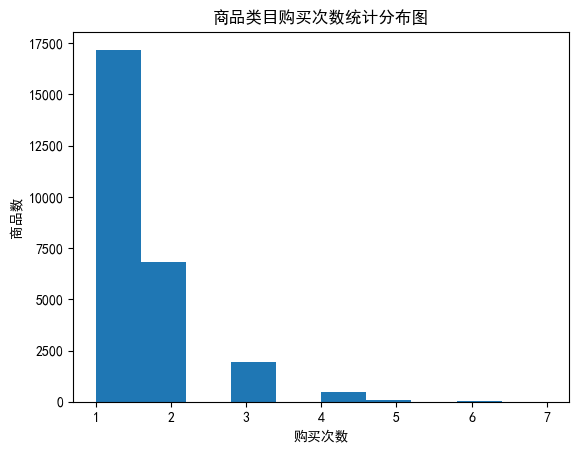

In [81]:
plt.hist(purchase['user_id'])
plt.title('商品类目购买次数统计分布图')
plt.xlabel('购买次数')
plt.ylabel('商品数')
plt.savefig('商品类目购买次数统计分布图.png')
plt.show()